# Redoing Taking features out of superposition with sparse autoencoders

This notebook is to recreate and play with "
[Interim research report] Taking features out of superposition with sparse autoencoders" by Lee Sharkey, Dan Braun, beren

https://www.lesswrong.com/posts/z6QQJbtpkEAX3Aojj/interim-research-report-taking-features-out-of-superposition

**Started:** 2023.05.30 

**Author:** Adam Shai

**Change Log:**
* 2023.05.30 - AS: Implemented the Toy Dataset Generation and the first two plots from the LW post
* 2023.05.31 - AS: Cleaned up code, made plots nicer. Added tqdm bars

## Toy Dataset Generation

In [1]:
import numpy as np
from scipy.stats import norm
from tqdm import tqdm
import matplotlib.pyplot as plt

np.random.seed(42)

def generate_toy_data(num_samples, feature_dim=256, num_ground_truth_features=512, num_active_features=5, decay_rate=0.99):
    """
    Generate a toy dataset for testing sparse linear regression algorithms.

    Parameters:
    -----------
    num_samples : int
        The number of samples to generate.
    feature_dim : int, optional (default=256)
        The dimensionality of the feature space.
    num_ground_truth_features : int, optional (default=512)
        The number of ground truth features to generate.
    num_active_features : int, optional (default=5)
        The number of active features for each sample, in expectation.
    decay_rate : float, optional (default=0.99)
        The decay rate for the feature probabilities.

    Returns:
    --------
    dataset : ndarray of shape (num_samples, feature_dim)
        The generated dataset.
    ground_truth_features : ndarray of shape (feature_dim, num_ground_truth_features)
        The ground truth features.
    sparse_coefficients : ndarray of shape (num_samples, num_ground_truth_features)
        The sparse ground truth feature coefficients.
    """
    
    # Step 1: Ground truth features
    ground_truth_features = np.random.randn(feature_dim, num_ground_truth_features) # Initialize with Gaussian random variables
    ground_truth_features /= np.linalg.norm(ground_truth_features, axis=0) # Normalize to lie on h-dimensional sphere

    # Step 2: Sparse ground truth feature coefficients
    sparse_coefficients = np.zeros((num_samples, num_ground_truth_features))
    dataset = np.zeros((num_samples, feature_dim))

    # Create covariance matrix and multivariate normal distribution
    covariance = np.random.randn(num_ground_truth_features, num_ground_truth_features)
    covariance = covariance @ covariance.T

    # rescale covariance matrix to have unit variance
    # covariance /= np.sqrt(np.trace(covariance))

    min_eigenvalue = np.min(np.linalg.eigvals(covariance))
    max_eigenvalue = np.max(np.linalg.eigvals(covariance))
    print(f"The min and max eigenvalue of the covariance matrix are {min_eigenvalue:.4f} and {max_eigenvalue:.4f}.")
    plt.hist(np.linalg.eigvals(covariance), bins=100)
    plt.title("Eigenvalues of covariance matrix")
    plt.figure()
    plt.hist(covariance.flatten(), bins=100)
    plt.title("Entries of covariance matrix")

    mean = np.zeros(num_ground_truth_features)
    # Create correlated activations for all samples at once
    samples = np.random.multivariate_normal(mean, covariance, size=num_samples)
    correlated_feature_probs = norm.cdf(samples)

    for i in tqdm(range(num_samples)):
        # Decay feature probabilities exponentially
        decayed_feature_probs = np.power(correlated_feature_probs[i], np.arange(num_ground_truth_features) * decay_rate)

        # Rescale probabilities
        mean_prob = np.mean(decayed_feature_probs)
        rescaled_probs = decayed_feature_probs/mean_prob

        rescaled_probs = num_active_features * rescaled_probs / num_ground_truth_features

        # clip probabilities to be between 0 and 1 (this is not necessary if everything is going well)
        # rescaled_probs = np.clip(rescaled_probs, 0, 1)

        # Sample from Bernoulli random variables
        binary_vector = np.random.binomial(1, rescaled_probs)
        
        # Scale by a random uniform variable to get 'activation'
        activations = binary_vector * np.random.uniform(0, 1, num_ground_truth_features)

        sparse_coefficients[i] = activations

        # Create data sample by linearly combining features
        dataset[i] = np.dot(ground_truth_features, activations)

    return dataset, ground_truth_features, sparse_coefficients


The min and max eigenvalue of the covariance matrix are 0.0075 and 1984.4260.


100%|██████████| 100000/100000 [00:20<00:00, 4954.18it/s]


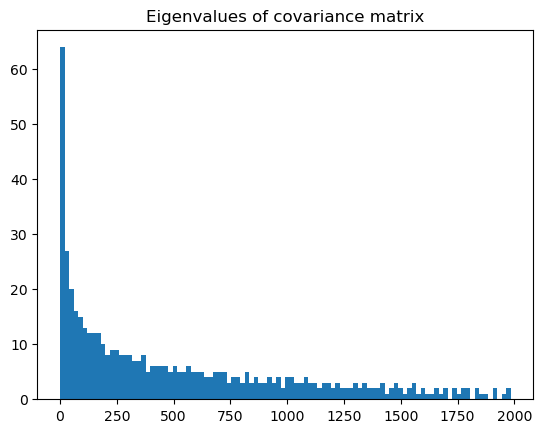

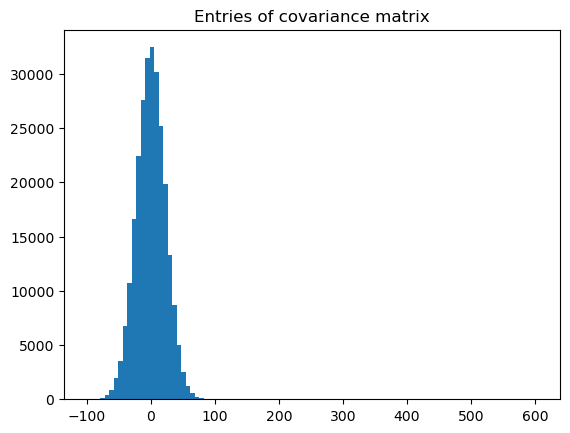

In [2]:
# Generate the toy dataset with N samples
num_samples = 100000
feature_dim = 256
num_ground_truth_features = 512
num_active_features = 5
dataset, ground_truth_features, sparse_coefficients = generate_toy_data(num_samples, feature_dim, num_ground_truth_features, num_active_features)


Text(0.5, 1.0, 'Distribution of number of non-zero coefficients')

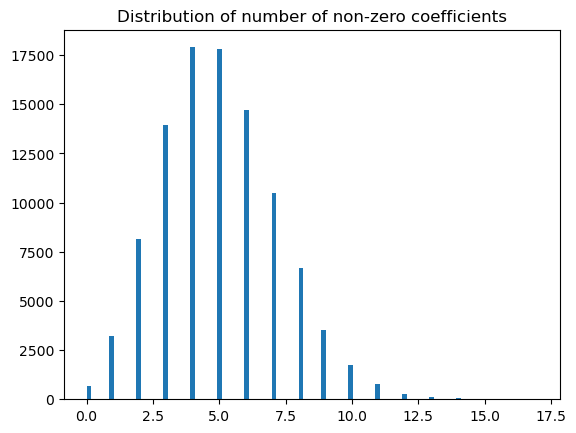

In [3]:
# Plot distribution of number of non-zero coefficients
sums = np.sum(sparse_coefficients>0, axis=1)
plt.hist(sums, bins=100)
plt.title("Distribution of number of non-zero coefficients")

## Autoencoder

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn import init

class Autoencoder(nn.Module):
    def __init__(self, feature_dim, code_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Linear(feature_dim, code_dim)
        self.decoder = nn.Linear(code_dim, feature_dim, bias=False) # this is a dictionary of features
        init.xavier_uniform_(self.encoder.weight)
        init.orthogonal_(self.decoder.weight)
        # divide the encoder weights by sqrt(2) to make the decoder weights orthogonal to the encoder weights

    def forward(self, x):
        c = F.relu(self.encoder(x))
        prediction = self.decoder(c)
        return c, prediction

## Training Functions

In [5]:
from tqdm.notebook import tqdm
def train_model(alpha, num_epochs, batch_size, dataset, device, feature_dim, code_dim, pbar):
    """
    Trains the autoencoder model.
    Returns the model and a history of losses during training.
    """
    num_samples = dataset.shape[0]
    model = Autoencoder(feature_dim, code_dim).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=100, verbose=False, factor=0.5)
    mse_loss = nn.MSELoss()  # define the base loss function

        
    loss_history = []

    for epoch in range(num_epochs):
        X = dataset[np.random.choice(num_samples, batch_size, replace=False)].to(device)  # get batch data
        c, outputs = model(X)
        mse, l1_loss = calculate_losses(outputs, X, c, alpha, code_dim, batch_size, mse_loss)
        final_loss = mse + l1_loss
        loss_history.append(final_loss.item())
        
        optimizer.zero_grad()
        final_loss.backward()
        optimizer.step()
        scheduler.step(final_loss)
        pbar.update(1)
        pbar.set_description(f"Loss: {final_loss.item():.2e} | L1 Loss: {l1_loss.item():.2e} | MSE Loss: {mse.item():.2e} | LR: {optimizer.param_groups[0]['lr']:.2e}")
    return model, loss_history


def calculate_losses(outputs, X, c, alpha, code_dim, batch_size, mse_loss):
    """
    Calculates MSE and L1 losses.
    """
    mse = mse_loss(outputs, X)
    l1_reg = torch.abs(c).sum()
    l1_loss = alpha * l1_reg / code_dim / batch_size
    return mse, l1_loss


def get_cosine_similarity(model, ground_truth_features):
    """
    Calculates cosine similarity.
    """
    decoder_weights = model.decoder.weight.detach().cpu().numpy()
    cos_sims = np.dot(ground_truth_features.T, decoder_weights) / \
        (np.linalg.norm(ground_truth_features, axis=0)[:, None] * np.linalg.norm(decoder_weights, axis=0))
    largest_cosine_similarity = np.max(cos_sims, axis=1)
    mean_cos_sim = np.mean(largest_cosine_similarity)
    return mean_cos_sim


## Sweep over L1 regularization strengths (alpha)

In [6]:
alpha_values = np.logspace(-3, 3, 30)
mean_cos_sims = []
num_epochs = 2000
batch_size = 256
ground_truth_features = ground_truth_features
feature_dim = feature_dim
code_dim = num_ground_truth_features

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# if dataset is numpy array, convert to torch tensor
if isinstance(dataset, np.ndarray):
    dataset = torch.from_numpy(dataset).float().to(device)

pbar_outer = tqdm(alpha_values, desc="Alpha values", position=0)
pbar_inner = tqdm(total=num_epochs, desc="Epochs ", position=1, leave=True)
for alpha in pbar_outer:
    pbar_inner.reset(total=num_epochs)
    model, loss_history = train_model(alpha, num_epochs, batch_size, dataset, device, feature_dim, code_dim, pbar_inner)
    mean_cos_sim = get_cosine_similarity(model, ground_truth_features)
    mean_cos_sims.append(mean_cos_sim)
    pbar_outer.set_postfix({"Alpha:": alpha, "Mean Max Cosine Similarity": mean_cos_sim})
    


Alpha values:   0%|          | 0/30 [00:00<?, ?it/s]

Epochs :   0%|          | 0/2000 [00:00<?, ?it/s]

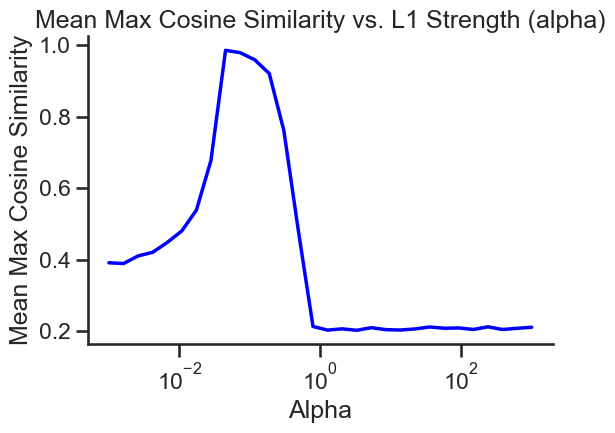

In [16]:
import seaborn as sns
import pandas as pd
import matplotlib.ticker as ticker

# prepare the data
data = pd.DataFrame({
    'Alpha': alpha_values,
    'Mean Max Cosine Similarity': mean_cos_sims,
})

# create the plot
sns.set(style="ticks")  # this gives a white background without grid
sns.set_context("talk")  # change the font size
plt.figure(figsize=(6, 4))  # adjust the size of the plot
sns.lineplot(data=data, x='Alpha', y='Mean Max Cosine Similarity', color='blue', linewidth=2.5)
plt.xscale('log')

# Add tick marks
ax = plt.gca()

# box off
sns.despine()
plt.title('Mean Max Cosine Similarity vs. L1 Strength (alpha)')
plt.show()


## Sweep through dictionary sizes (code_dim)

In [17]:
alpha = 0.1
mean_cos_sims = []
num_epochs = 2000
batch_size = 256
ground_truth_features = ground_truth_features
feature_dim = feature_dim
code_dims = np.logspace(-1, 2,20)*num_ground_truth_features
# make sure code_dims is int
code_dims = code_dims.astype(int)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# if dataset is numpy array, convert to torch tensor
if isinstance(dataset, np.ndarray):
    dataset = torch.from_numpy(dataset).float().to(device)

pbar_outer = tqdm(code_dims, desc="Code Dims", position=0)
pbar_inner = tqdm(total=num_epochs, desc="Epochs ", position=1, leave=True)
for code_dim in pbar_outer:
    pbar_inner.reset(total=num_epochs)
    model, loss_history = train_model(alpha, num_epochs, batch_size, dataset, device, feature_dim, code_dim, pbar_inner)
    mean_cos_sim = get_cosine_similarity(model, ground_truth_features)
    mean_cos_sims.append(mean_cos_sim)
    pbar_outer.set_postfix({"Code Dim:": code_dim, "Mean Max Cosine Similarity": mean_cos_sim})


Code Dims:   0%|          | 0/20 [00:00<?, ?it/s]

Epochs :   0%|          | 0/2000 [00:00<?, ?it/s]

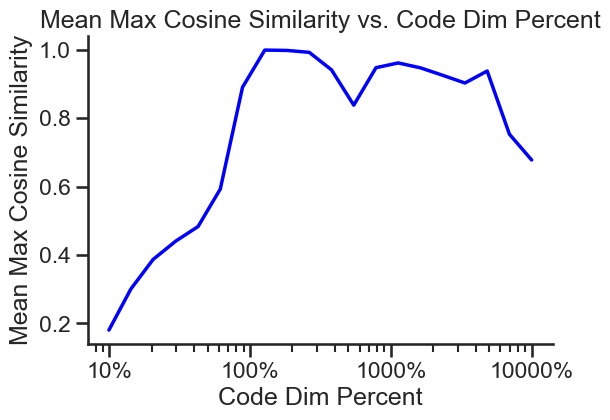

In [19]:
# plot results
# import percentage formatter
from matplotlib.ticker import PercentFormatter
# prepare the data
data = pd.DataFrame({
    'Code Dim Percent': code_dims/num_ground_truth_features*100,
    'Mean Max Cosine Similarity': mean_cos_sims,
})

# create the plot
sns.set(style="ticks")  # this gives a white background without grid
sns.set_context("talk")  # change the font size
plt.figure(figsize=(6, 4))  # adjust the size of the plot
sns.lineplot(data=data, x='Code Dim Percent', y='Mean Max Cosine Similarity', color='blue', linewidth=2.5)
plt.xscale('log')

# box off
sns.despine()
plt.title('Mean Max Cosine Similarity vs. Code Dim Percent')

plt.gca().xaxis.set_major_formatter(PercentFormatter())